# Thicket Nsight Compute Reader: Thicket Tutorial

Nsight Compute (NCU) is a performance profiler for NVIDIA GPUs. NCU report files do not have a calltree, but with the NVTX Caliper service we can forward Caliper annotations to NCU. By profiling the same executable with a calltree profiler like Caliper, we can map the NCU data to the calltree profile and create a Thicket object. 

In Section 6, we reproduce some of the analysis and visualizations from the paper:

Olga Pearce, Jason Burmark, Rich Hornung, Befikir Bogale, Ian Lumsden, Michael McKinsey, Dewi Yokelson, David Boehme, Stephanie Brink, Michela Taufer, and Tom Scogland. “RAJA Performance Suite: Performance Portability Analysis with Caliper and Thicket”. SC-W 2024: Workshops of ACM/IEEE International Conference for High Performance Computing, Networking, Storage, and Analysis. Performance, Portability & Productivity in HPC. 2024.

***

## 1. Import Necessary Packages

The Thicket NCU reader requires an existing install of Nsight Compute, and the `extras/python` directory in the Nsight Compute installation directory must be added to the `PYTHONPATH`. We use `sys.path.append` to add the path to the `PYTHONPATH` in this notebook. If you are not on a Livermore Computing system, you must change this path to match your install of Nsight Compute.

**VERSION NOTICE: This functionality is tested with nsight-compute version 2023.2.2. Your mileage may vary if using a different version.**

In [1]:
import os
import sys

sys.path.append("/usr/tce/packages/nsight-compute/nsight-compute-2023.2.2/extras/python")

from IPython.display import display
from IPython.display import HTML

import thicket as tt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

display(HTML("<style>.container { width:80% !important; }</style>"))

Seaborn not found, so skipping imports of plotting in thicket.stats
To enable this plotting, install seaborn or thicket[plotting]


## 2. The Dataset

The dataset we are using comes from a profile of the RAJA Performance Suite on Lassen. We profile the `block_128` tuning of the `Base_CUDA`, `Lambda_CUDA`, and `RAJA_CUDA` variants, while varying the problem size for 1 million and 2 million. The calltree profiles come from the CUDA Activity Profile Caliper configuration. By changing the `variant` argument in the following cell, we can look at NCU data for different variants.

The following are reproducible steps to generate this dataset:

```
# Example of building
$ . RAJAPerf/scripts/lc-builds/blueos_nvhpc_nvcc_clang_caliper.sh 
$ make -j

# Load CUDA version equal to the CUDA version used to build RAJAPerf
$ module load nvhpc/24.1-cuda-11.2.0

# Turn off NVIDIA Data Center GPU Manager (DCGM) on Lassen so we can run NCU (get an error if it's on)
$ dcgmi profile --pause
```

```
# Example run to Generate the CUDA Activity Profile
$ CALI_CONFIG=cuda-activity-profile,output.format=cali lrun -n 1 --smpiargs="-disable_gpu_hooks" bin/raja-perf.exe --variants [Base_CUDA OR Lambda_CUDA OR RAJA_CUDA] --tunings block_128 --size [1048576 OR 2097152] --repfact 0.01

# Example run to Generate the NCU Report
$ CALI_SERVICES_ENABLE=nvtx lrun -n 1 --smpiargs="-disable_gpu_hooks" ncu \
--nvtx --set default \
--export report \
--metrics sm__throughput.avg.pct_of_peak_sustained_elapsed \
--replay-mode application \
bin/raja-perf.exe --variants [Base_CUDA OR Lambda_CUDA OR RAJA_CUDA] --tunings block_128 --size [1048576 OR 2097152] --repfact 0.01
```

In [2]:
# Map all files
ncu_dir = "../data/ncu/"
ncu_report_mapping = {}
variant = "base_cuda" # OR "lambda_cuda" OR "raja_cuda"
problem_sizes = ["1M", "2M"]
for problem_size in problem_sizes:
    full_path = f"{ncu_dir}{variant}/{problem_size}/"
    ncu_report_mapping[full_path + "report.ncu-rep"] = full_path + "cuda_profile.cali"

## 3. Read Calltree Profiles into Thicket

The only performance metrics contained in the CUDA Activity Profile will be the CPU time `time` and the GPU time `time (gpu)`.

In [3]:
tk_cap = tt.Thicket.from_caliperreader(list(ncu_report_mapping.values()))
tk_cap.dataframe.head(20)

(2/2) Creating Thicket: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


nid      time  \
node                                               profile                      
{'name': 'RAJAPerf', 'type': 'function'}           457195964   23.0  0.000615   
                                                   528105777   23.0  0.000596   
{'name': 'Algorithm', 'type': 'function'}          457195964  164.0  0.000024   
                                                   528105777  164.0  0.000024   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964  168.0  0.000017   
                                                   528105777  168.0  0.000017   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  170.0  0.000061   
                                                   528105777  170.0  0.000039   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  169.0  0.000031   
                                                   528105777  169.0  0.000032   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964  225.0       NaN   
                                                   528105777  225.0       NaN   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964  165.0  0.000015   
                                                   528105777  165.0  0.000014   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  167.0  0.000043   
                                                   528105777  167.0  0.000030   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  166.0  0.000030   
                                                   528105777  166.0  0.000029   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964  224.0       NaN   
                                                   528105777  224.0       NaN   

                                                              time (gpu)  \
node                                               profile                 
{'name': 'RAJAPerf', 'type': 'function'}           457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm', 'type': 'function'}          457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964    0.000051   
                                                   528105777    0.000031   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964    0.000033   
                                                   528105777    0.000020   

                                                                                                           name  
node                                               profile                                                       
{'name': 'RAJAPerf', 'type': 'function'}           457195964                                           RAJAPerf  
                                                   528105777                                           RAJAPerf  
{'name': 'Algorithm', 'type': 'function'}          457195964                                          Algorithm  
                                      

## 4. Add NCU Data

The Thicket `add_ncu` function takes one required argument and one optional arguement. The required argument `ncu_report_mapping` is the mapping from the NCU report file to the corresponding calltree profile run. The optional argument `chosen_metrics` allows for a subselection of the NCU performance metrics to add, since there can be hundreds of NCU performance metrics. By default we add all metrics.

In [4]:
# Add NCU to thicket
ncu_metrics = [
    "gpu__time_duration.sum",
    "sm__throughput.avg.pct_of_peak_sustained_elapsed",
    "smsp__maximum_warps_avg_per_active_cycle",
]
# Add in metrics
tk_cap.add_ncu(
    ncu_report_mapping=ncu_report_mapping, 
    chosen_metrics=ncu_metrics,
)
tk_cap.dataframe.head(20)

Processing action 600/601: 100%|██████████| 601/601 [00:01<00:00, 375.43it/s]


nid      time  \
node                                               profile                      
{'name': 'RAJAPerf', 'type': 'function'}           457195964   23.0  0.000615   
                                                   528105777   23.0  0.000596   
{'name': 'Algorithm', 'type': 'function'}          457195964  164.0  0.000024   
                                                   528105777  164.0  0.000024   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964  168.0  0.000017   
                                                   528105777  168.0  0.000017   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  170.0  0.000061   
                                                   528105777  170.0  0.000039   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  169.0  0.000031   
                                                   528105777  169.0  0.000032   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964  225.0       NaN   
                                                   528105777  225.0       NaN   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964  165.0  0.000015   
                                                   528105777  165.0  0.000014   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964  167.0  0.000043   
                                                   528105777  167.0  0.000030   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964  166.0  0.000030   
                                                   528105777  166.0  0.000029   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964  224.0       NaN   
                                                   528105777  224.0       NaN   

                                                              time (gpu)  \
node                                               profile                 
{'name': 'RAJAPerf', 'type': 'function'}           457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm', 'type': 'function'}          457195964         NaN   
                                                   528105777         NaN   
{'name': 'Algorithm_MEMCPY', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memcpy<128u... 457195964    0.000051   
                                                   528105777    0.000031   
{'name': 'Algorithm_MEMSET', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaDeviceSynchronize', 'type': 'func... 457195964         NaN   
                                                   528105777         NaN   
{'name': 'cudaLaunchKernel', 'type': 'function'}   457195964         NaN   
                                                   528105777         NaN   
{'name': 'void rajaperf::algorithm::memset<128u... 457195964    0.000033   
                                                   528105777    0.000020   

                                                                                                           name  \
node                                               profile                                                        
{'name': 'RAJAPerf', 'type': 'function'}           457195964                                           RAJAPerf   
                                                   528105777                                           RAJAPerf   
{'name': 'Algorithm', 'type': 'function'}          457195964                                          Algorithm   
                                 

## 5. Visualize the NCU Performance Data on the Calltree

In [5]:
print(tk_cap.tree(
    metric_column="sm__throughput.avg.pct_of_peak_sustained_elapsed",
    expand_name=True,
    ))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.2.1

nan RAJAPerf
├─ nan Algorithm
│  ├─ nan Algorithm_MEMCPY
│  │  ├─ nan cudaDeviceSynchronize
│  │  └─ nan cudaLaunchKernel
│  │     └─ 6.521 void rajaperf::algorithm::memcpy<128ul>(double*, double*, long)
│  └─ nan Algorithm_MEMSET
│     ├─ nan cudaDeviceSynchronize
│     └─ nan cudaLaunchKernel
│        └─ 7.532 void rajaperf::algorithm::memset<128ul>(double*, double, long)
├─ nan Apps
│  ├─ nan Apps_DEL_DOT_VEC_2D
│  │  ├─ nan cudaDeviceSynchronize
│  │  └─ nan cudaLaunchKernel
│  │     └─ 26.952 void rajaperf::apps::deldotvec2d<128ul>(double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, long*, double, double, long)
│  ├─ nan Apps_EDGE3D
│  │  └─ nan cudaDeviceSynchronize
│  ├─ nan Apps_ENERGY
│  │  ├─ 

## 6. Create Instruction Roofline Plots

We can make roofline plots using the metrics we have collected using Nsight Compute. The Roofline sets an upper bound on performance of a kernel depending on its operational intensity. We will use roofline plots to understand the performance of RAJAPerf kernels.

In this section, we reproduce some of the analysis and visualizations from the paper:

Olga Pearce, Jason Burmark, Rich Hornung, Befikir Bogale, Ian Lumsden, Michael McKinsey, Dewi Yokelson, David Boehme, Stephanie Brink, Michela Taufer, and Tom Scogland. “RAJA Performance Suite: Performance Portability Analysis with Caliper and Thicket”. SC-W 2024: Workshops of ACM/IEEE International Conference for High Performance Computing, Networking, Storage, and Analysis. Performance, Portability & Productivity in HPC. 2024.

Instruction Roofline Models were introduced by Ding et. al to better characterize GPU workloads by looking at instruction intensity. We walk through the creation of instruction roofline models for the Appications group of the RAJAPerf kernels below. 

More references on methodology for roofline models:

* Samuel Williams, Andrew Waterman, and David Patterson. 2009. Roofline: an insightful visual performance model for multicore architectures. Commun. ACM 52, 4 (April 2009), 65–76. https://doi.org/10.1145/1498765.1498785

* Nan Ding, Muaaz Awan, Samuel Williams. 2022. Instruction Roofline: An insightful visual performance model for GPUs. Concurrency and Computation: Practice and Experience
https://doi.org/10.1002/cpe.6591

Step 1 is to create a Thicket using a CUDA Activity Profile, and add the NCU data. We use `RAJA_CUDA` variant data of the `block_256` tuning.

Command to generate the Caliper CUDA Activity Profile:
```
CALI_CONFIG=cuda-activity-profile,output.format=cali lrun -n 1 --smpiargs="-disable_gpu_hooks" bin/raja-perf.exe --variants RAJA_CUDA --tunings block_256 --size 8388608
```

Command to generate the NCU report with Roofline metrics:
```
CALI_SERVICES_ENABLE=nvtx lrun -n 1 --smpiargs="-disable_gpu_hooks" ncu \
--nvtx --set default \
--export report \
--metrics sm__sass_thread_inst_executed.sum,l1tex__t_sectors_pipe_lsu_mem_global_op_ld.sum,l1tex__t_sectors_pipe_lsu_mem_global_op_st.sum,l1tex__t_sectors_pipe_lsu_mem_local_op_ld.sum,l1tex__t_sectors_pipe_lsu_mem_local_op_st.sum,lts__t_sectors_op_read.sum,lts__t_sectors_op_write.sum,lts__t_sectors_op_atom.sum,lts__t_sectors_op_red.sum,dram__sectors_read.sum,dram__sectors_write.sum,l1tex__data_pipe_lsu_wavefronts_mem_shared_op_ld.sum,l1tex__data_pipe_lsu_wavefronts_mem_shared_op_st.sum \
--replay-mode application \
bin/raja-perf.exe --variants RAJA_CUDA --tunings block_256 --size 8388608
```

In [6]:
roofline_cali = ncu_dir + "roofline/block_256_profile.cali"
roofline_ncu = ncu_dir + "roofline/block_256_profile.ncu-rep"

# Unzip files, unless they have already been unzipped
if not (os.path.isfile(roofline_cali) and os.path.isfile(roofline_ncu)):
    import zipfile
    with zipfile.ZipFile(ncu_dir + "roofline/block_256_profile.zip", "r") as zip_ref:
        zip_ref.extractall(ncu_dir + "roofline/")

# Create Thicket and add NCU data
tk_roofline = tt.Thicket.from_caliperreader(roofline_cali)
tk_roofline.add_ncu({roofline_ncu:roofline_cali})

Processing action 3444/3445: 100%|██████████| 3445/3445 [00:42<00:00, 81.94it/s] 


Select a subset of kernels to plot on the roofline. Here we are just selecting `Apps` kernels.

In [7]:
# Options (can be more than one): ["Algorithm", "Apps", "Basic", "Comm", "Lcals", "Polybench", "Stream"]
kernel_types = ["Apps"]

raja_kernel_query = (
    tt.query.Query()
    .match (
        ".",
        lambda row: row["name"].apply(
            lambda x: any([x.startswith(c + "_") for c in kernel_types])
        ).all()
    )
    .rel("*")
)

pruned_th = tk_roofline.query(raja_kernel_query)

Aggregate metrics for kernels with multiple instances

In [8]:
# Match parent kernel name, e.g. "Apps_VOL3D"
kernel_query = """
MATCH (".",p)->("*")
WHERE p."name" = "{ker}"
"""

# Match demangled kernel that contains NCU measurement.
child_kernel_query = """
MATCH (".", p)
WHERE p."depth" = 2
"""

# List of columns to exclude from aggregation
cols = [col for col in pruned_th.dataframe.columns.tolist() if col not in ["nid", "time", "name", "time (inc)", "time (gpu) (inc)"]]
leaves = []

for n in pruned_th.graph.roots:
    kernels = {}
    
    kernels["name"] = n.frame.get("name")

    tmp = kernel_query.format(ker=n.frame.get("name"))
    ker_th = pruned_th.query(tmp, multi_index_mode="all")
    leaf = ker_th.query(child_kernel_query, multi_index_mode="all")
    for col in cols:
        kernels[col] = leaf.dataframe[col].sum()
    
    leaves.append(kernels)

agg_df = pd.DataFrame(data=leaves)
agg_df

,name,time (gpu),c2clink__enabled_mask,c2clink__present,device__attribute_architecture,device__attribute_async_engine_count,device__attribute_can_flush_remote_writes,device__attribute_can_map_host_memory,device__attribute_can_tex2d_gather,device__attribute_can_use_64_bit_stream_mem_ops_v1,...,sm__sass_thread_inst_executed.sum,smsp__inst_executed.sum,smsp__inst_executed_op_global_ld.sum,smsp__inst_executed_op_global_st.sum,smsp__inst_executed_op_local_ld.sum,smsp__inst_executed_op_local_st.sum,smsp__inst_executed_op_shared_ld.sum,smsp__inst_executed_op_shared_st.sum,smsp__inst_executed_pipe_tensor.sum,smsp__maximum_warps_avg_per_active_cycle
0,Apps_DEL_DOT_VEC_2D,0.000527,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,1.165767e+09,3.643023e+07,4455496.0,262088.0,0.000000e+00,0.0,0.0,0.0,0.0,10.0
1,Apps_EDGE3D,0.468591,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,1.898933e+11,5.934178e+09,6587736.0,274489.0,1.089172e+09,715043845.0,0.0,0.0,0.0,2.0
2,Apps_ENERGY,0.002247,0.0,0.0,1920.0,24.0,6.0,6.0,6.0,6.0,...,1.811939e+09,5.662310e+07,5767168.0,1572864.0,0.000000e+00,0.0,0.0,0.0,0.0,96.0
3,Apps_FIR,0.000178,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,1.115685e+09,3.486515e+07,4194304.0,262144.0,0.000000e+00,0.0,0.0,0.0,0.0,16.0
4,Apps_LTIMES,0.002227,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,3.340763e+09,1.216348e+08,18874368.0,8388608.0,0.000000e+00,0.0,0.0,0.0,0.0,16.0
5,Apps_LTIMES_NOVIEW,0.002234,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,2.900361e+09,1.042022e+08,18874368.0,8388608.0,0.000000e+00,0.0,0.0,0.0,0.0,16.0
6,Apps_MATVEC_3D_STENCIL,0.002154,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,1.731645e+09,5.411398e+07,14378100.0,261420.0,0.000000e+00,0.0,0.0,0.0,0.0,4.0
7,Apps_NODAL_ACCUMULATION_3D,0.000556,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,3.597146e+08,1.124110e+07,522840.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,16.0
8,Apps_PRESSURE,0.000507,0.0,0.0,640.0,8.0,2.0,2.0,2.0,2.0,...,5.117051e+08,1.599078e+07,1048576.0,786432.0,0.000000e+00,0.0,0.0,0.0,0.0,32.0
9,Apps_VOL3D,0.000380,0.0,0.0,320.0,4.0,1.0,1.0,1.0,1.0,...,1.317547e+09,4.117341e+07,6587736.0,274489.0,0.000000e+00,0.0,0.0,0.0,0.0,8.0


Calculate instruciton intensities from existing NCU metrics.

In [9]:
# Warp Instructions
agg_df["Warp Instructions"] = agg_df["sm__sass_thread_inst_executed.sum"] / 32
# L1 Global Count Memory Transactions
agg_df["L1 (GLOBAL)"] = agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_ld.sum"] + agg_df["l1tex__t_sectors_pipe_lsu_mem_global_op_st.sum"]
agg_df["L1 (SHARED)"] = agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_ld.sum"] + agg_df["l1tex__data_pipe_lsu_wavefronts_mem_shared_op_st.sum"]
agg_df["Total L1 Transactions"] = agg_df["L1 (GLOBAL)"] + (4 * agg_df["L1 (SHARED)"])
# Shared Count Memory Transactions
agg_df["L2 Write Transactions"] =  agg_df["lts__t_sectors_op_write.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["L2 Read Transactions"] =  agg_df["lts__t_sectors_op_read.sum"] + agg_df["lts__t_sectors_op_atom.sum"] + agg_df["lts__t_sectors_op_red.sum"]
agg_df["Total L2 Transactions"] = agg_df["L2 Read Transactions"] + agg_df["L2 Write Transactions"]
# HBM Count Memory Transactions
agg_df["HBM Transactions"] = agg_df["dram__sectors_read.sum"] +  agg_df["dram__sectors_write.sum"]
# L1, L2, HBM Intensities
agg_df["L1 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L1 Transactions"]
agg_df["L2 Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["Total L2 Transactions"]
agg_df["HBM Instruction Intensity"] = agg_df["Warp Instructions"] / agg_df["HBM Transactions"]
# Performance in GIPS
agg_df["Performance GIPS"] = agg_df["Warp Instructions"] / (agg_df["time (gpu)"] * (10 ** 9))

### Plotting Roofline with Matplotlib

The plotting code below was adapted from the following resource: https://gitlab.com/NERSC/roofline-on-nvidia-gpus/-/blob/master/custom-scripts/roofline.py

In [14]:
pruned_th_kers = tk_roofline.query(child_kernel_query, multi_index_mode="all")
metrics = ["L1 Instruction Intensity", "L2 Instruction Intensity", "HBM Instruction Intensity"]

c_s = ["red", "blue", "green", "orange", "purple", "cyan", "magenta"]
final_colors = []
for i in agg_df["name"].tolist():
    for j in range(0, len(kernel_types)):
        if i.startswith(kernel_types[j]):
            final_colors.append(c_s[j])
            continue

font = {"size": 15}
plt.rc("font", **font)

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
styles = ["o", "s", "v", "^", "D", ">", "<", "*", "h", "H", "+", "1", "2", "3", "4", "8", "p", "d", "|", "_", ".", ","]

markersize = 10
markerwidth = 2
maxchar = 25

def roofline(LABELS, flag="HBM", data_df=None):
    LABELS = [x[:maxchar] for x in LABELS]
    
    bandiwdth_hbm = 25.9 # in GTXN/s
    bandwidth_l2 = 93.6 # in GTXN/s
    bandwidth_l1 = 437.5 # in GTXN/s
    
    if flag == "L1":
        memRoofs = [("L1", bandwidth_l1)]
    elif flag == "L2":
        memRoofs = [("L2", bandwidth_l2)]
    elif flag == "HBM":
        memRoofs = [("HBM", bandiwdth_hbm)]
    elif flag == "all":
        memRoofs = [("L1", bandwidth_l1), ("L2", bandwidth_l2),  ("HBM", bandiwdth_hbm)]

    cmpRoofs = [("GIPS", 489.6)]

    fig = plt.figure(1, figsize=(10,6))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Instruction Intensity [Warp Instructions/transaction]")
    ax.set_ylabel("Performance [Warp GIPS]")

    nx   = 10000
    xmin = -3 
    xmax = 3
    ymin = 1
    ymax = 1000

    ax.set_xlim(10 ** xmin, 10 ** xmax)
    ax.set_ylim(ymin, ymax)

    ixx = int(nx * 0.02)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    scomp_x_elbow  = []
    scomp_ix_elbow = []
    smem_x_elbow   = []
    smem_ix_elbow  = []

    x = np.logspace(xmin, xmax, nx)
    for roof in cmpRoofs:
        for ix in range(1, nx):
            if float(memRoofs[0][1] * x[ix]) >= roof[1] and (memRoofs[0][1] * x[ix - 1]) < roof[1]:
                scomp_x_elbow.append(x[ix - 1])
                scomp_ix_elbow.append(ix - 1)
                break

    for roof in memRoofs:
        for ix in range(1, nx):
            if (cmpRoofs[0][1] <= roof[1] * x[ix] and cmpRoofs[0][1] > roof[1] * x[ix - 1]):
                smem_x_elbow.append(x[ix - 1])
                smem_ix_elbow.append(ix - 1)
                break

    for i in range(len(cmpRoofs)):
        roof = cmpRoofs[i][1]
        y = np.ones(len(x)) * roof
        ax.plot(x[scomp_ix_elbow[i]:], y[scomp_ix_elbow[i]:], c="k", ls="-", lw="2")

    for i in range(len(memRoofs)):
        roof = memRoofs[i][1]
        y = x * roof
        ax.plot(x[:smem_ix_elbow[i] + 1], y[:smem_ix_elbow[i] + 1], c="k", ls="-", lw="2")

    for roof in cmpRoofs:
        ax.text(
            x[-ixx],
            roof[1],
            roof[0] + ": " + "{0:.1f}".format(roof[1]) + " Warp GIPS",
            horizontalalignment="right",
            verticalalignment="bottom"
        )

    for roof in memRoofs:
        ang = np.arctan(np.log10(xlim[1] / xlim[0]) / np.log10(ylim[1] / ylim[0])
                                   * fig.get_size_inches()[1] / fig.get_size_inches()[0] )
        if x[ixx]*roof[1] > ymin:
            ax.text(
                x[ixx],
                x[ixx] * roof[1] * (1 + 0.25 * np.sin(ang) ** 2),
                roof[0] + ": " + "{0:.1f}".format(float(roof[1])) + " GTXN/s",
                horizontalalignment="left",
                verticalalignment="bottom",
                rotation=180 / np.pi * ang
            )
        else:
            ymin_ix_elbow=list()
            ymin_x_elbow=list()
            for ix in range(1, nx):
                if (ymin <= roof[1] * x[ix] and ymin > roof[1] * x[ix - 1]):
                    ymin_x_elbow.append(x[ix - 1])
                    ymin_ix_elbow.append(ix - 1)
                    break
            ax.text(
                x[ixx+ymin_ix_elbow[0]],
                x[ixx+ymin_ix_elbow[0]] * roof[1] * (1 + 0.25 * np.sin(ang) ** 2) * 1.15,
                roof[0] + ": " + "{0:.1f}".format(float(roof[1])) + " GTXN/s",
                horizontalalignment="left",
                verticalalignment="bottom",
                rotation=180 / np.pi * ang
            )

    if flag == "L1":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
    elif flag == "L2":
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
    elif flag == "HBM":
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    elif flag == "all":
        ax.scatter(data_df[metrics[0]], data_df["Performance GIPS"], c=final_colors, label="L1", marker=styles[0])
        ax.scatter(data_df[metrics[1]], data_df["Performance GIPS"], c=final_colors, label="L2", marker=styles[1])
        ax.scatter(data_df[metrics[2]], data_df["Performance GIPS"], c=final_colors, label="HBM", marker="*")

    custom_labels = [k.split("_")[0] for k in kernel_types]
    custom_handles = [plt.Line2D([0], [0], color=i, lw=2) for i in c_s]
    
    if flag == "HBM":
        leg2 = ax.legend(
            custom_handles,
            custom_labels,
            bbox_to_anchor=(0.36, 1),
            title="Kernel Types",
            fontsize="12",          # Adjust label font size (e.g., "small", "medium", "large", or specific size)
            title_fontsize="small"
        )
    else:
        leg2 = ax.legend(
            custom_handles,
            custom_labels,
            bbox_to_anchor=(0.36, 1),
            title="Kernel Types",
            fontsize="12",          # Adjust label font size (e.g., "small", "medium", "large", or specific size)
            title_fontsize="small"
        )
        
    ax.add_artist(leg2)
    
    ax.legend(loc="upper left")
    plt.show()

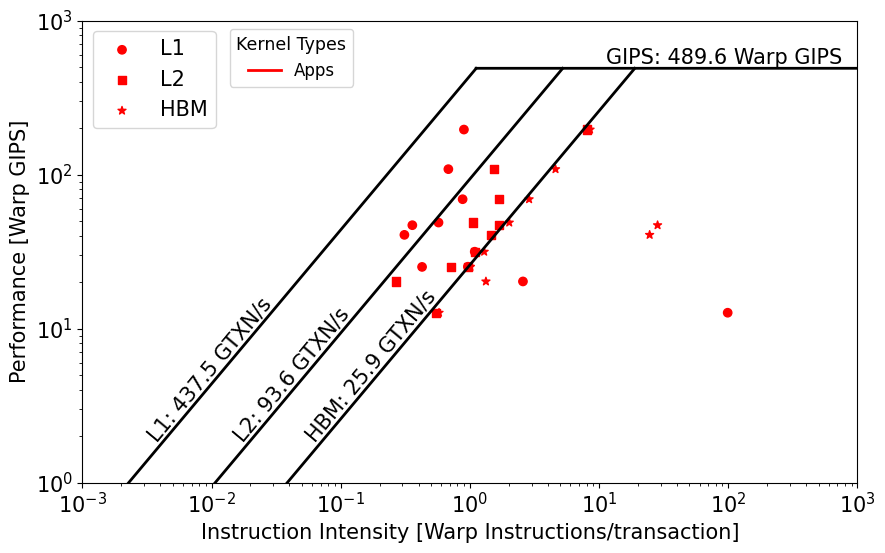

In [15]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag="all", data_df=agg_df)

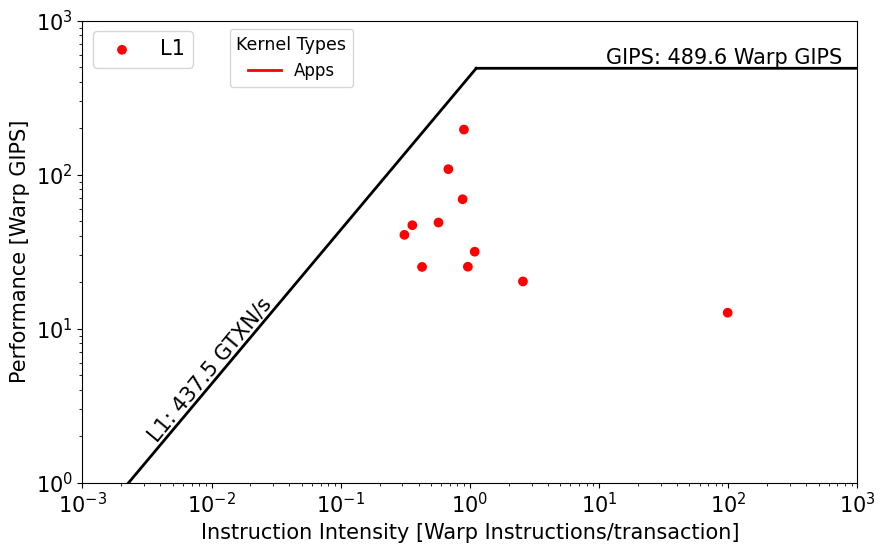

In [16]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag="L1", data_df=agg_df)

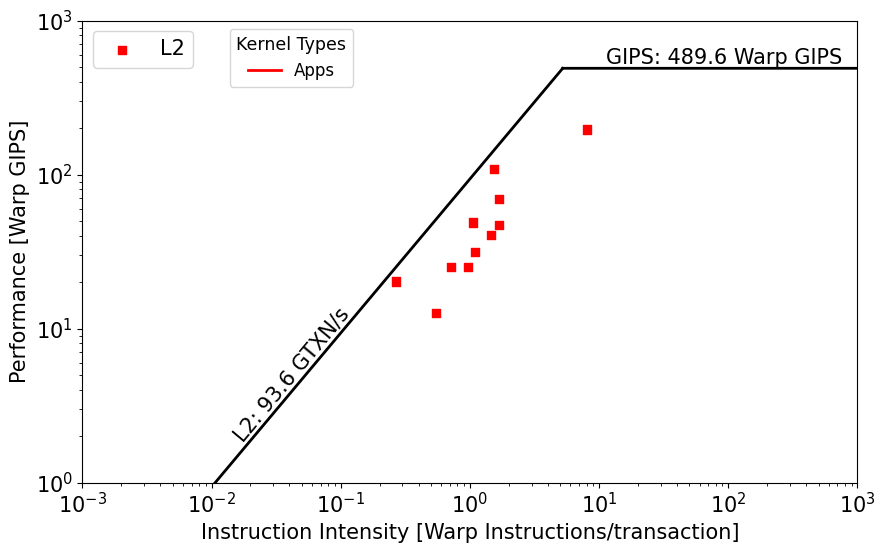

In [17]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag="L2", data_df=agg_df)

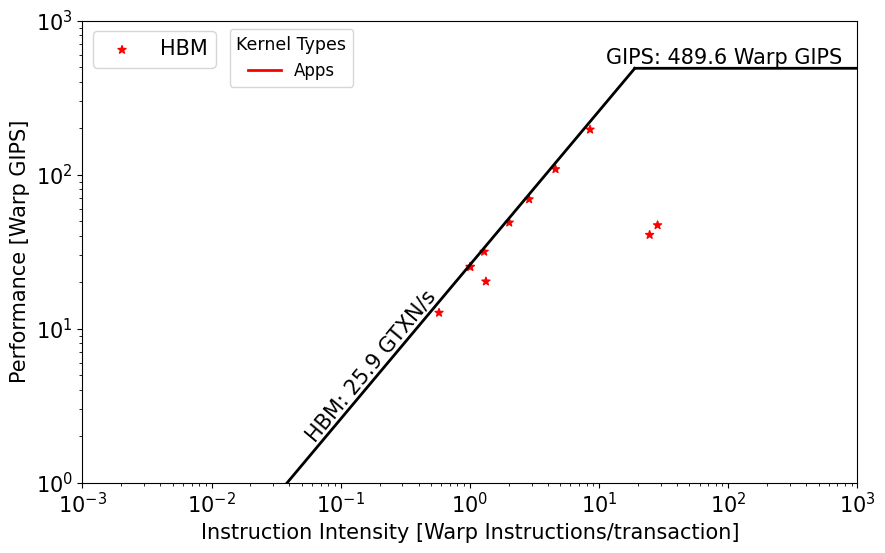

In [18]:
roofline(LABELS=pruned_th.dataframe["name"].tolist(), flag="HBM", data_df=agg_df)